# Prediction of the probability of death of a patient that is entering an ICU (Intensive Care Unit)
## Using KNN and SVM

#### Andrés Felipe Virgüez Clavijo

This notebook shows the process of fitting KNN and SVM models into a dataset from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.  

The data used in this notebook results from a pre-processing process that is detailed in the notebook Data_preparation.ipynb (https://github.com/andresvBSE/BSE-CML2-P12/blob/main/Data_preparation.ipynb)

In [302]:
import pandas as pd
import numpy as np

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [188]:
import sys
sys.path.append('src/features')

from customplots import *
from reweight_proba import *

## Load the data

In [2]:
train = pd.read_csv('data/processed/train.csv') 
train.set_index('icustay_id', inplace=True)

print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 228357 to 258400
Columns: 811 entries, HeartRate_Min to ICD9_0_L1_1_2_3
dtypes: float64(811)
memory usage: 129.4 MB
None


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_O_10_L1_ICD9_CODE_O_6_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_7_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_8_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_9_L1,GENDER_ICD9DIAG,AGE_ICD9DIAG,GENDER_AGE_ICD9DIAG,ICD9_diagnosis_1_2,ICD9_0_L1_1_2,ICD9_0_L1_1_2_3
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,1.33218,1.948876,2.403148,-1.006425,-1.021078,-0.772756,-0.202861,0.088173,-0.127848,0.189415,...,1.509058,-0.398645,0.929949,0.367890,-0.720769,0.232231,0.355083,-0.187505,-0.222547,0.394449
221004,-0.46234,0.234689,-0.405068,-0.127652,-1.279621,-0.763765,0.399285,-0.764372,0.202969,0.117851,...,-0.866732,-0.909108,-0.905278,-0.872673,-0.225775,-0.270395,-0.528072,-0.246277,-0.177883,-0.847985
296315,0.78002,-0.353032,0.437012,-0.186237,-0.547081,-0.392030,0.055202,-1.137360,-0.532373,0.547234,...,1.856850,0.058470,-0.864646,-0.206783,-0.077142,-0.255789,0.369981,-0.101701,-0.191736,0.177013
245557,0.43492,1.116271,0.917094,-0.420577,-0.676353,-0.749047,-1.235111,0.034889,-1.922454,-0.597786,...,-0.520172,-0.677242,-0.700432,-0.290224,-0.352110,-0.306233,-0.432051,-0.472576,-0.253667,0.405987
292786,0.71100,0.430596,0.744087,-1.182180,-0.503991,-1.047845,-1.235111,-1.563633,-1.922454,-0.884041,...,-0.506747,-0.664903,-0.679860,-0.322564,-0.666738,-0.381377,0.218631,-0.403414,-0.956360,-0.462257


In [3]:
test = pd.read_csv('data/processed/test.csv')
test.set_index('icustay_id', inplace=True)
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5221 entries, 286120 to 286384
Columns: 810 entries, HeartRate_Min to ICD9_0_L1_1_2_3
dtypes: float64(810)
memory usage: 32.3 MB
None


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_O_10_L1_ICD9_CODE_O_6_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_7_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_8_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_9_L1,GENDER_ICD9DIAG,AGE_ICD9DIAG,GENDER_AGE_ICD9DIAG,ICD9_diagnosis_1_2,ICD9_0_L1_1_2,ICD9_0_L1_1_2_3
icustay_id,,,,,,,,,,,,,,,,,,,,,
286120,0.02080,-0.010194,0.022425,0.399611,-0.762534,-0.099920,0.227244,-0.657804,-0.368620,0.332543,...,-0.665465,-1.859467,-1.366493,-1.256403,-0.429993,-0.337667,-1.282706,-0.481984,-0.430885,-1.534544
248206,0.60747,0.234689,0.550471,0.546073,1.413541,1.248266,0.184233,0.221383,0.806786,0.296761,...,1.106359,-0.067872,-0.497785,0.202090,-0.668973,-0.395110,0.458094,-0.651950,0.869419,0.838465
293175,-0.80744,0.724457,0.140758,0.048102,2.383079,0.063354,-0.374902,0.461162,-0.846234,0.046288,...,-0.410181,-0.724168,-0.541266,0.452246,0.062963,1.314272,0.256677,-0.049629,-0.381478,-0.079716
240974,0.02080,-1.528474,-0.983438,0.399611,-0.934897,-0.663219,-0.202861,-1.989905,-1.489938,0.117851,...,0.157968,0.013478,-1.776884,-0.095481,1.539817,1.186751,3.854509,-0.240216,1.058680,0.546156
202015,0.26237,-0.867288,-0.563214,-0.391284,-1.365803,-1.280389,-0.159850,-0.471309,-0.765732,-0.132622,...,0.516158,0.984634,0.792480,-0.798425,-0.209156,0.700259,-1.080735,-0.251975,-1.114369,0.683819


In [5]:
# Create the X, y and target objects
target = 'HOSPITAL_EXPIRE_FLAG'
y = train[target]
X_train = train.drop(target, axis=1)
X_test = test
print(X_train.shape)
print(X_test.shape)

(20885, 810)
(5221, 810)


In [7]:
feature_names = X_test.columns

# KNN

## Base line Knn model

First, I fit a KNN model with the default parameters and the data that I prepared in the Notebook: "Data preparation". Since the kaggle competition is based in the Area Under the Curve (AUC) of the Receiving Operating Characteristic line (ROC) I am focused on this metric. The average AUC from this first model is the started point from wich I expect to improve by hyperparamenter tunning and dealing the class imbalance.

In [183]:
# Initial libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, f1_score

In [332]:
# Fist model with default parameters 
model_knn_bl = KNeighborsClassifier()
splitter = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

metrics = []
# Split train data into train and validation to predict over unobserved data
for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    model_knn_bl.fit(train_df, train_y)
    predictions = model_knn_bl.predict_proba(val_df)
    metrics.append(roc_auc_score(val_y, predictions[:,1]))

Above, I use kfold splits to validate the model over data that was not observed by the model in the fittingm process

In [334]:
print(metrics)
print(np.mean(metrics))

[0.7929081476574594, 0.798857653480172, 0.7774652511828284, 0.793152533679269, 0.7880776423016678]
0.7900922456602794


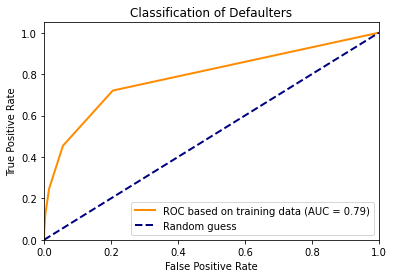

In [335]:
# Plot of the Roc curve and AUC using a function from my module (customplots) in the validation data
roc_curve_plot(val_y, predictions[:,1])

Now I fit this basic model with the full data (no validation data)

In [22]:
model_knn_bl.fit(X_train, y)
y_train_hat_knn_bl = model_knn_bl.predict_proba(X_train)

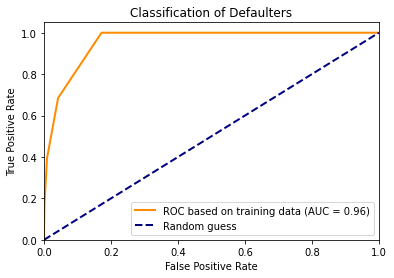

In [23]:
roc_curve_plot(y, y_train_hat_knn_bl[:,1])

See the huge difference of the AUC when predicts observed data and when there were not observed data. This overfitting is expected since we haven't started to find the best paramenters of the knn model.

Lets send predicictions of this basic model to kaggle to have some information from the leaderboard.

In [25]:
y_test_hat_knn_bl = model_knn_bl.predict_proba(test[feature_names])

test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_bl[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_bl.csv", index = False)

## A better approach -  Class imbalance and hyperparameter tunning

Onwards I will follow try to improve the predictions by searching a way to del with the class imbalance and by doing hyperparameter tunning over the number of neighbors, the distance and if the distance is weighted.

### Class imbalance

Which one is the best approach to class imbalance ?

In [190]:
import imblearn

from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule, TomekLinks

In [228]:
under_sampling = [RandomUnderSampler(random_state=123),
                  NearMiss(),
                  OneSidedSelection(random_state=123), 
                  NeighbourhoodCleaningRule(),
                  TomekLinks()]

reweight = [ReweightProba(reweight=False), ReweightProba(reweight=True)]

In [244]:
def class_imbalance_pipeline(model, classb_method, reweight_method):

    splitter = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    fits_data = {}
    fits_data['method'] = []; fits_data['reweighted'] = []; fits_data['nrows'] = []; fits_data['auc'] = []; fits_data['f1'] = []

    for train_index, val_index in splitter.split(X_train, y):
        train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
        train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

        for method in classb_method:
            for j, adjust in enumerate(reweight_method):
                X_resampled, y_resampled = method.fit_resample(train_df, train_y)

                model.fit(X_resampled, y_resampled)
                predictions = model.predict_proba(val_df)

                reweighted_transformer = adjust
                reweighted_transformer.fit(predictions[:,1], y.mean() ,0.5)
                predictions_a = reweighted_transformer.transform(predictions[:,1])

                fits_data['method'].append(str(method)[:10])
                fits_data['reweighted'].append(j)
                fits_data['nrows'].append(X_resampled.shape[0])
                fits_data['auc'].append(roc_auc_score(val_y, predictions_a))
                fits_data['f1'].append(f1_score(val_y, (predictions_a > 0.5).astype(int)))

    return pd.DataFrame(fits_data)

model_knn_bl = KNeighborsClassifier()

df_fits_under = class_imbalance_pipeline(model_knn_bl, under_sampling, reweight)
df_fits_under.groupby(['method', 'reweighted'])['auc', 'f1'].mean()

auc        f1
method     reweighted                    
NearMiss() 0           0.809772  0.446022
           1           0.809772  0.289587
Neighbourh 0           0.833107  0.494112
           1           0.833107  0.259410
OneSidedSe 0           0.789187  0.364320
           1           0.789187  0.088269
RandomUnde 0           0.844075  0.448690
           1           0.844075  0.365706
TomekLinks 0           0.789260  0.364320
           1           0.789260  0.088269

The table above shows that the reweight of probabilities do not affect the auc (for that reason I included the F1) and the F1 score is better if I do not reweighted the probabilities.

Besides, according with the above table, the best strategy for dealing with class imbalance by the under-sampling approach is the Random undersampling. However this algorith's drawback is that is trained with same amount of rows whose target value is 1. This means that uses only around 12% of the training data.

Another good algorithm to use is the Neighborhood Cleaning Rule NCR (NeighbourhoodCleaningRule()), this method belongs to the family of Cleaning under-sampling techniques, which consist in clear the noisy observations of the dataset (cleaning the data) instead of create a balanced data. The method of NCR is show in the next table, it performs a process in which noisy rows are droped. 

The full explanation of NCR is available in https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2001-Laurikkala-LNCS.pdf

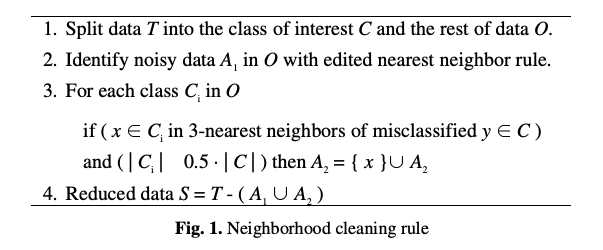

Lets see now how well a couple of algorithms for over sampling from imblearn work in constrast with the undersampling methods

In [237]:
# Classes for over samplig from imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, ADASYN, BorderlineSMOTE

In [245]:
# Algorithm to use with default paramenters (only choose the radom_state)
over_sampling = [RandomOverSampler(random_state=123),
                 SMOTE(random_state=123),
                 ADASYN(random_state=123), 
                 BorderlineSMOTE(random_state=123)]

In [246]:
df_fits_over = class_imbalance_pipeline(model_knn_bl, over_sampling, reweight)
df_fits_over.groupby(['method', 'reweighted'])['auc', 'f1'].mean()

auc        f1
method     reweighted                    
ADASYN(ran 0           0.763994  0.271630
           1           0.763994  0.362083
Borderline 0           0.787103  0.292251
           1           0.787103  0.392064
RandomOver 0           0.783184  0.449111
           1           0.783184  0.433596
SMOTE(rand 0           0.772339  0.277340
           1           0.772339  0.372561

The table above shows that in this case, the reweight improves F1 score in all of the methods (shoud I use a different function to reweight if I do undersampling?). However the performance in both the AUC and the F1 is lower in all the methods of oversampling in constrast with undersampling.

According with the above, I will use the NCR method for under sampling. However I want to do a smalll grid search over the parameters of the NCR method to work with the best approach to balanced data possible.

#### Grid search over the choosen method for dealing with imbalanced classes

The next loop does grid search over a list of NeighbourhoodCleaningRule() classes with different values for number of nerigbors and the method to select the row to eliminate from the data.

In [298]:
# List (with) names of the methods of NCR to fit over
NCR_gs = [('default', NeighbourhoodCleaningRule()),
                 ('k=1, sel=all', NeighbourhoodCleaningRule(n_neighbors = 1, kind_sel = "all")),
                 ('k=5, sel=all', NeighbourhoodCleaningRule(n_neighbors = 5, kind_sel = "all")),
                 ('k=10, sel=all', NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")),
                 ('k=15, sel=all', NeighbourhoodCleaningRule(n_neighbors = 20, kind_sel = "all")),
                 ('k=20, sel=all', NeighbourhoodCleaningRule(n_neighbors = 20, kind_sel = "all")),
                 ('k=1, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 1, kind_sel = "mode")),
                 ('k=5, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 5, kind_sel = "mode")),
                 ('k=10, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "mode")),
                 ('k=15, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "mode")),
                 ('k=20, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 20, kind_sel = "mode"))]

# The splitter is a stratifield k fold since we have imbalanced data
splitter = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Dictionary to save results 
data = {}; data['Params'] = []; data['AUC'] = []

# Loop that splits the data into training and validation 5 times, for each method. It is a grid search made by hand.
for train_index, val_index in splitter.split(X_train, y):
        train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
        train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

        for name, method in NCR_gs:
            X_resampled, y_resampled = method.fit_resample(train_df, train_y)

            model_knn_bl.fit(X_resampled, y_resampled)
            predictions = model_knn_bl.predict_proba(val_df)
            
            data['Params'].append(name)
            data['AUC'].append(roc_auc_score(val_y, predictions[:,1]))
            
# Data and data.frame
df_fits_NCR = pd.DataFrame(data)
df_fits_NCR.groupby(['Params'])['AUC'].mean()

Params
default           0.833107
k=1, sel=all      0.811232
k=1, sel=mode     0.811232
k=10, sel=all     0.851447
k=10, sel=mode    0.850478
k=15, sel=all     0.849540
k=15, sel=mode    0.850478
k=20, sel=all     0.849540
k=20, sel=mode    0.849533
k=5, sel=all      0.841145
k=5, sel=mode     0.840507
Name: AUC, dtype: float64

So I will use the selection parameter with value all for 10 neighboors

In [264]:
model_knn_bl_r = KNeighborsClassifier()
resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")

print(X_train.shape, y.shape)
X_resampled, y_resampled = resampling_m1.fit_resample(X_train, y)
print(X_resampled.shape, y_resampled.shape)

(20885, 810) (20885,)
(17902, 810) (17902,)


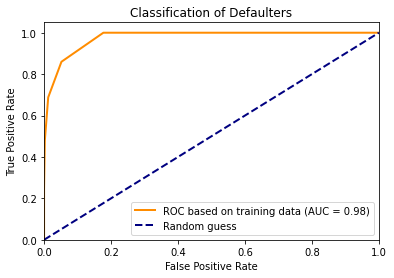

In [267]:
model_knn_bl_r.fit(X_resampled, y_resampled)
y_train_hat_knn_bl_r = model_knn_bl_r.predict_proba(X_resampled)

roc_curve_plot(y_resampled, y_train_hat_knn_bl_r[:,1])

In [268]:
y_test_hat_knn_bl_r = model_knn_bl_r.predict_proba(X_test)

test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_bl_r[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_bl_r.csv", index = False)

The new predictions are better. However the model overfits which is normal because I haven't started the hyperparameter tunning

### Hyper parameter tunning

In [299]:
parameters1 = {'n_neighbors' : [50, 100, 300, 600], 
               'weights' : ['uniform', 'distance'],
               'p': [1,2]}

results = {'n_neighbors' : [], 
           'weights' : [],
           'p': [],
           'AUC' : []}

from datetime import datetime
start_time = datetime.now()

resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")
splitter = StratifiedKFold(n_splits=4, random_state=123, shuffle=True, )

metrics = []
for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    X_resampled, y_resampled = resampling_m1.fit_resample(train_df, train_y)
    
    for k in parameters1['n_neighbors']:
        for weight in parameters1['weights']:
            for p in parameters1['p']:
                model = KNeighborsClassifier(n_neighbors = k,
                                             weights = weight,
                                             algorithm = 'kd_tree', # The faster: the three algorithms give the same AUC
                                             p = p)
                model.fit(X_resampled, y_resampled)
                predictions = model.predict_proba(val_df)

                results['n_neighbors'].append(k)
                results['weights'].append(weight)
                results['p'].append(p)
                auc = roc_auc_score(val_y, predictions[:,1])
                results['AUC'].append(auc)
                print('k:', k, weight, 'p:', p, ' : ', auc)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

k: 50 uniform p: 1  :  0.8565403961047433
k: 50 uniform p: 2  :  0.8684683790652927
k: 50 distance p: 1  :  0.8656728212309497
k: 50 distance p: 2  :  0.8721817002328406
k: 100 uniform p: 1  :  0.8556373346270966
k: 100 uniform p: 2  :  0.8671391475496601
k: 100 distance p: 1  :  0.862376113895275
k: 100 distance p: 2  :  0.8696285392420091
k: 300 uniform p: 1  :  0.8536196887249631
k: 300 uniform p: 2  :  0.8635695370201912
k: 300 distance p: 1  :  0.8574985895407324
k: 300 distance p: 2  :  0.8647443990524654
k: 600 uniform p: 1  :  0.852337135600727
k: 600 uniform p: 2  :  0.8606502998259667
k: 600 distance p: 1  :  0.8550257374358861
k: 600 distance p: 2  :  0.8615452752830567
k: 50 uniform p: 1  :  0.8689417954353836
k: 50 uniform p: 2  :  0.8785279314902563
k: 50 distance p: 1  :  0.8773735231636421
k: 50 distance p: 2  :  0.8819834248244732
k: 100 uniform p: 1  :  0.8694051419125145
k: 100 uniform p: 2  :  0.8771056768687573
k: 100 distance p: 1  :  0.875818726045705
k: 100 dist

In [301]:
results_gs_knn1 = pd.DataFrame(results)
results_gs_knn1.groupby(['n_neighbors', 'weights', 'p'])['AUC'].mean().sort_values(ascending=False)

n_neighbors  weights   p
50           distance  2    0.876031
             uniform   2    0.872471
100          distance  2    0.872321
             uniform   2    0.869788
50           distance  1    0.868604
300          distance  2    0.866603
100          distance  1    0.866221
300          uniform   2    0.865211
600          distance  2    0.862877
             uniform   2    0.861789
50           uniform   1    0.860338
300          distance  1    0.860091
100          uniform   1    0.859843
300          uniform   1    0.856145
600          distance  1    0.855966
             uniform   1    0.853030
Name: AUC, dtype: float64

<AxesSubplot:xlabel='n_neighbors', ylabel='AUC'>

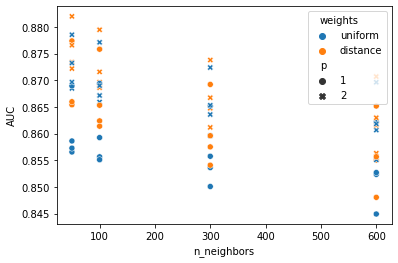

In [305]:
sns.scatterplot(x='n_neighbors', y='AUC', hue = 'weights',  style = 'p', data = results_gs_knn1)

From the graph above we see that the data adjust better when weight is set as distance and p as 2. Besides the results improve as we decrease the number of neighbors

Lets fit this model to send it to the kaggle competition.

In [306]:
# Initialization of model and resampling method
model_knn_m1 = KNeighborsClassifier(weights = 'distance', p = 2, n_neighbors = 50, algorithm = 'kd_tree')
resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")

# Getting the resample data
X_resampled, y_resampled = resampling_m1.fit_resample(X_train, y)

# FIt the model in the resampled data and get the predicted proba on this data
model_knn_m1.fit(X_resampled, y_resampled)

# Predict in the test data
y_test_hat_knn_m1 = model_knn_m1.predict_proba(X_test)

0.14288450488412183


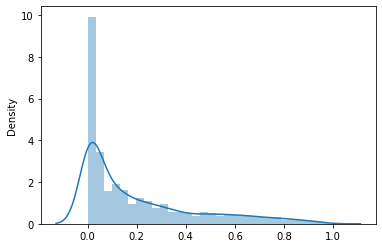

In [321]:
# Plot of the distribution of the predicted probabilities
sns.distplot(y_test_hat_knn_m1[:,1])
print((y_test_hat_knn_m1[:,1] > 0.5).astype(int).mean()) # proportion of predicted deads

The model with 50 neighbors predicts a 14% of dead patients in the test data (p > 0.5), this is informative since is more than what we saw in the training data (without any adjustment for class imbalance). However, the metric to optimize is the AUC, and from the grid search we get into the conclution that this is the best fitting over a set of different 16 different models.

In [308]:
# Export the data
test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_m1[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_m1.csv", index = False)

#### More grid search

We saw that on average the AUC increased in the left hand part of the graph. In this section I will try a new grid search only for number of neighbors (k) to get the best value for this parameter

In [311]:

start_time = datetime.now()

resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")
splitter = StratifiedKFold(n_splits=4, random_state=123, shuffle=True, )

parameters2 = {'n_neighbors' : [10, 20, 30, 40, 50, 60, 80, 100]}

results = {'n_neighbors' : [], 
           'AUC' : []}

for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    X_resampled, y_resampled = resampling_m1.fit_resample(train_df, train_y)
    
    for k in parameters2['n_neighbors']:
        model = KNeighborsClassifier(n_neighbors = k,
                                     weights = 'distance',
                                     algorithm = 'kd_tree',
                                     p = 2)
        model.fit(X_resampled, y_resampled)
        predictions = model.predict_proba(val_df)

        results['n_neighbors'].append(k)
        auc = roc_auc_score(val_y, predictions[:,1])
        results['AUC'].append(auc)
        print('k: ', k, 'AUC: ', auc)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

k:  10 AUC:  0.8709371881598607
k:  20 AUC:  0.8751555180658239
k:  30 AUC:  0.8742862708559604
k:  40 AUC:  0.8731523902460538
k:  50 AUC:  0.8721817002328406
k:  60 AUC:  0.8721896024802032
k:  80 AUC:  0.8699143065594166
k:  100 AUC:  0.8696285392420091
k:  10 AUC:  0.8780866754291985
k:  20 AUC:  0.8811027535703636
k:  30 AUC:  0.8843191181505904
k:  40 AUC:  0.8843272179698172
k:  50 AUC:  0.8819834248244732
k:  60 AUC:  0.8812179919075442
k:  80 AUC:  0.8800460953348723
k:  100 AUC:  0.8794695354753674
k:  10 AUC:  0.8694148985129467
k:  20 AUC:  0.8750440887887457
k:  30 AUC:  0.8751381571438565
k:  40 AUC:  0.8734579969147053
k:  50 AUC:  0.8733876757568728
k:  60 AUC:  0.8726117498923094
k:  80 AUC:  0.8692291549311332
k:  100 AUC:  0.8686148572775034
k:  10 AUC:  0.8697416525840264
k:  20 AUC:  0.8744310797427203
k:  30 AUC:  0.8752743813763065
k:  40 AUC:  0.876163152449643
k:  50 AUC:  0.8765727455809963
k:  60 AUC:  0.874777531101465
k:  80 AUC:  0.8733427585775244
k:  100

In [319]:
results_gs_knn1 = pd.DataFrame(results)
results_gs_knn1.groupby('n_neighbors').agg({'AUC': ['mean', 'var']})

AUC          
                 mean       var
n_neighbors                    
10           0.872045  0.000017
20           0.876433  0.000010
30           0.877254  0.000022
40           0.876775  0.000027
50           0.876031  0.000019
60           0.875199  0.000017
80           0.873133  0.000024
100          0.872321  0.000024

Lets train a model with the full trained (and undersampled) data to send predictions to the kaggle competition. 

In [329]:
# Initialization of model
model_knn_m2 = KNeighborsClassifier(weights = 'distance', p = 2, n_neighbors = 30, algorithm = 'kd_tree')

# Fit the model in the resampled data and get the predicted proba on this data
model_knn_m2.fit(X_resampled, y_resampled)

# Predict in the test data
y_test_hat_knn_m2 = model_knn_m2.predict_proba(X_test)

0.15897337674774947


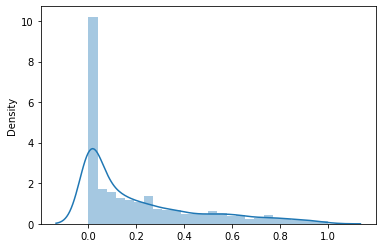

In [330]:
# Plot of the distribution of the predicted probabilities
sns.distplot(y_test_hat_knn_m2[:,1])
print((y_test_hat_knn_m2[:,1] > 0.5).astype(int).mean()) # proportion of predicted deads

In [331]:
# Export the data
test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_m2[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_m2.csv", index = False)

With all of the above I have applied a class balace strategy and doing and hyperparameter tunning, which gets me into the best possible model according to the pre-processing  data made. At this point I improved my internal measurement of AUC from around 0.80 to a 0.87. Based on the kaggle public leaderboard my results improved from 0.79 on average to 0.85

The next section focus on fitting models with another algorithm that should get better results.

# SVM

## SVM base line model

In [10]:
from sklearn.svm import SVC